# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


np.random.seed(2020)
random.seed(2020)

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [2]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

## Gini index

In [4]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)

In [5]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [6]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [7]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

-0.0003705758273065962

## Entropy

In [8]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [9]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

# Split function

Implement split functions

In [10]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [11]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child and self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features=None, max_depth=None):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Fit two models with "max_depth=3" and "max_depth=None" hyperparameters. Explain the results.

In [12]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [13]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [14]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


# Random forest

In [15]:
class RandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values. By default is required, but if y_required = false
                then may be omitted.
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth,
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters. Explain the results.

In [16]:
model = RandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


In [17]:
model = RandomForestClassifier(n_estimators=100, max_depth=None, n_features=None, criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.8809523809523809


Now it's your turn to explore the various parameters of sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and their influence on model quality.

# Homework part 1. RandomForestClassifier

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

In [144]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import time
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import time
from joblib import Parallel, delayed
from joblib import Memory

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [19]:
# Your code here
y = df['target']
X = df.drop(columns='target')
# сначала разделим данные на тренировочную и тестовую часть (train = 60%, test+valid=40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
# после разделим тестовую часть на тестовую и валидационную
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

**Task 2 (2 points)**. Apply '_greedy_' hyperparameter tuning of RandomForestClassifier model. '_Greedy_' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric. <br>

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time **if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.**<br>

Here is one of the possible options for RandomForestClassifier:
- Choose a decent value for number of trees using '_elbow_' rule. You may plot the dependence of RMSE on trees_num and pick up the number after which the error decreases not **as much as before**. 
- Pick up the best split criterion ('gini' / 'entropy') and then tune _max_depth_, _min_samples_split_, _min_samples_leaf_.
- Increase number of trees with best found parameters so far.
- Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps **if you observe a significant test metric improvement**. Otherwise just stop and measure your best model result on validation set.

*Начнем подбор гиперпараметров в следующей очереди: n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf*

In [20]:
N_ESTIMATORS = 100
CRITERION = 'gini'
MAX_DEPTH = None
MIN_SAMPLES_SPLIT=2
MIN_SAMPLES_LEAF=1

In [21]:
#функция для оценки параметров модели
def acc_score(n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf):
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=0)
    model.fit(X_train, y_train)
    accur = cross_val_score(model,X_test, y_test, cv = 5)
    return(accur)

In [29]:
#зададим кол-во деревьев 
metrics = [100, 200, 800, 1200]
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=x, criterion=CRITERION, max_depth=MAX_DEPTH,
                                   min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF).mean()

100%|██████████| 4/4 [00:15<00:00,  3.96s/it]


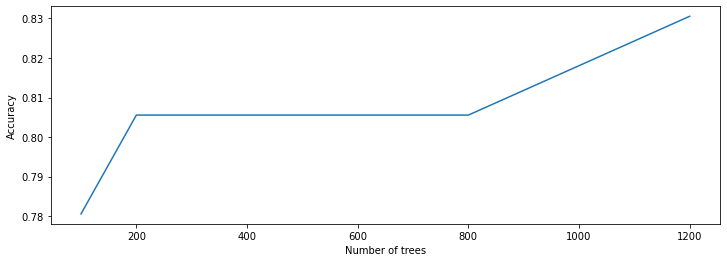

In [30]:
#создадим ряд со значениями точности модели и построим график
plot_score = np.array([results[x] for x in metrics])
plt.figure(figsize=(12,4))
ax = sns.lineplot(data=results)
ax.set(ylabel='Accuracy', xlabel='Number of trees')
plt.show()

In [31]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with the number of trees {}'.format(plot_score.max(), metrics[plot_score.argmax()]))
N_ESTIMATORS = metrics[plot_score.argmax()]

Max. accuracy 83.06% with the number of trees 1200


In [32]:
#зададим список критериев оценки модели
metrics = {0:'gini', 1:'entropy'}
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=N_ESTIMATORS, criterion=metrics[x], max_depth=MAX_DEPTH,
                                   min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF).mean()

100%|██████████| 2/2 [00:16<00:00,  8.35s/it]


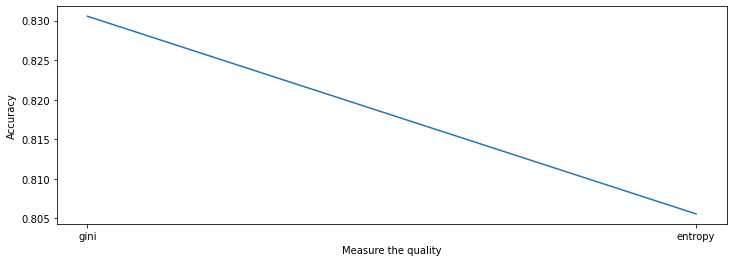

In [33]:
#создадим ряд со значениями точности модели и построим график
plot_score_2 = np.array([results[x] for x in metrics])

plt.figure(figsize=(12,4))
ax = sns.lineplot(x=list(metrics.values()), y=plot_score_2)
ax.set(ylabel='Accuracy', xlabel='Measure the quality')
plt.show()

In [34]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with "{}" measure the quality'.format(plot_score_2.max(), metrics[plot_score_2.argmax()]))
CRITERION = metrics[plot_score_2.argmax()]

Max. accuracy 83.06% with "gini" measure the quality


In [35]:
#зададим глубину дерева в интервале от 2 до 12 с шагом в 1
metrics = [x for x in range(2,13,1)]
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=N_ESTIMATORS, criterion=CRITERION, max_depth=x,
                                   min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF).mean()

100%|██████████| 11/11 [01:38<00:00,  9.00s/it]


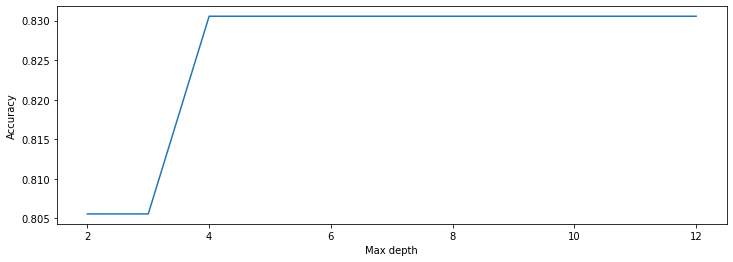

In [36]:
#создадим ряд со значениями точности модели и построим график
plot_score_3 = np.array([results[x] for x in metrics])

plt.figure(figsize=(12,4))
ax = sns.lineplot(x=metrics, y=plot_score_3)
ax.set(ylabel='Accuracy', xlabel='Max depth')
plt.show()

In [37]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with the depth of trees {}'.format(plot_score_3.max(), metrics[plot_score_3.argmax()]))
MAX_DEPTH = metrics[plot_score_3.argmax()]

Max. accuracy 83.06% with the depth of trees 4


In [38]:
#зададим минимальное число объектов, при котором выполняется расщепление в интервале от 2 до 8 с шагом в 1
metrics = [x for x in range(2,9,1)]
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=N_ESTIMATORS, criterion=CRITERION, max_depth=MAX_DEPTH,
                                   min_samples_split=x, min_samples_leaf=MIN_SAMPLES_LEAF).mean()

100%|██████████| 7/7 [01:01<00:00,  8.75s/it]


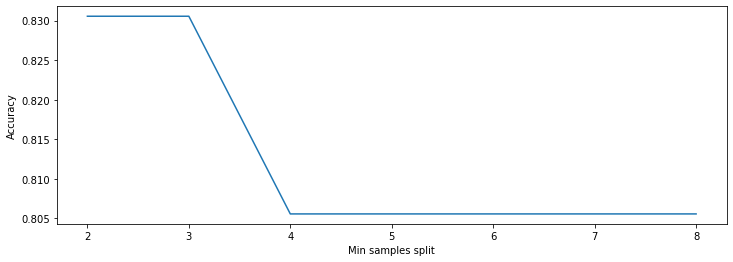

In [39]:
#создадим ряд со значениями точности модели и построим график
plot_score_4 = np.array([results[x] for x in metrics])

plt.figure(figsize=(12,4))
ax = sns.lineplot(x=metrics, y=plot_score_4)
ax.set(ylabel='Accuracy', xlabel='Min samples split')
plt.show()

In [40]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with the min samples split {}'.format(plot_score_4.max(), metrics[plot_score_4.argmax()]))
MIN_SAMPLES_SPLIT=metrics[plot_score_4.argmax()]

Max. accuracy 83.06% with the min samples split 2


In [41]:
#зададим ограничение на число объектов в листьях в интервале от 1 до 10 с шагом в 1
metrics = [x for x in range(1,11,1)]
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=N_ESTIMATORS, criterion=CRITERION, max_depth=MAX_DEPTH,
                                   min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=x).mean()

100%|██████████| 10/10 [01:28<00:00,  8.88s/it]


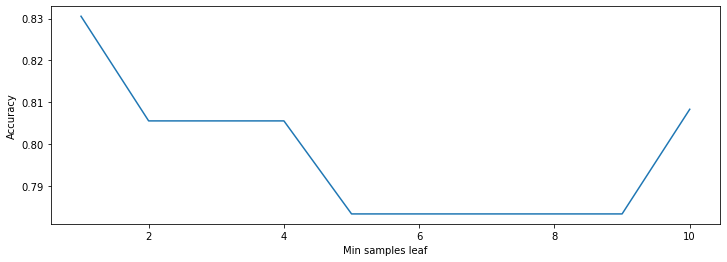

In [42]:
#создадим ряд со значениями точности модели и построим график
plot_score_5 = np.array([results[x] for x in metrics])

plt.figure(figsize=(12,4))
ax = sns.lineplot(x=metrics, y=plot_score_5)
ax.set(ylabel='Accuracy', xlabel='Min samples leaf')
plt.show()

In [43]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with the min samples leaf {}'.format(plot_score_5.max(), metrics[plot_score_5.argmax()]))
MIN_SAMPLES_LEAF=metrics[plot_score_5.argmax()]

Max. accuracy 83.06% with the min samples leaf 1


*Установим все показатели в модель*

In [44]:
model_classifier = RandomForestClassifier(n_estimators=N_ESTIMATORS, criterion=CRITERION, max_depth=MAX_DEPTH,
                                          min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF)
model_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=1200)

*Проверим точность модели на валидационных данных*

In [45]:
cross_val_score(model_classifier, X_valid, y_valid, cv = 5)

array([0.44444444, 0.77777778, 0.625     , 0.75      , 0.75      ])

In [50]:
print('Средняя точность модели составляет {:.2%}'.format(model_classifier.score(X_valid, y_valid)))

Средняя точность модели составляет 80.95%


In [55]:
model_classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

*После подбора гиперпараметров, снова попробуем изменить их и посмотреть на точность модели*

In [59]:
#зададим кол-во деревьев 
metrics = [100, 900, 1300, 1600]
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=x, criterion=CRITERION, max_depth=MAX_DEPTH,
                                   min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF).mean()

100%|██████████| 4/4 [00:28<00:00,  7.04s/it]


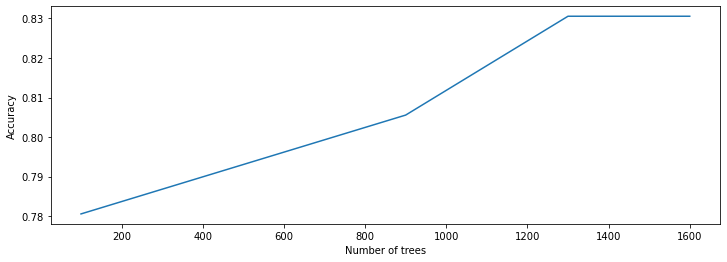

In [60]:
#создадим ряд со значениями точности модели и построим график
plot_score = np.array([results[x] for x in metrics])
plt.figure(figsize=(12,4))
ax = sns.lineplot(data=results)
ax.set(ylabel='Accuracy', xlabel='Number of trees')
plt.show()

In [61]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with the number of trees {}'.format(plot_score.max(), metrics[plot_score.argmax()]))
N_ESTIMATORS = metrics[plot_score.argmax()]

Max. accuracy 83.06% with the number of trees 1300


In [62]:
#зададим список критериев оценки модели
metrics = {0:'gini', 1:'entropy'}
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=N_ESTIMATORS, criterion=metrics[x], max_depth=MAX_DEPTH,
                                   min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF).mean()

100%|██████████| 2/2 [00:19<00:00,  9.65s/it]


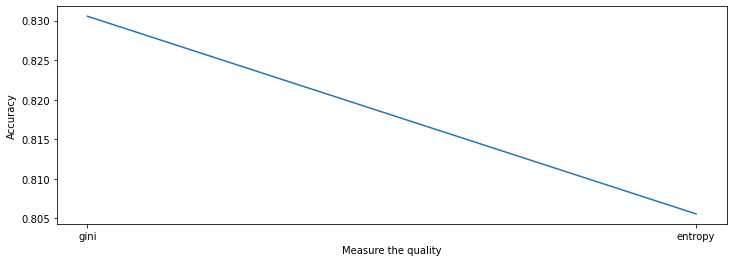

In [63]:
#создадим ряд со значениями точности модели и построим график
plot_score_2 = np.array([results[x] for x in metrics])

plt.figure(figsize=(12,4))
ax = sns.lineplot(x=list(metrics.values()), y=plot_score_2)
ax.set(ylabel='Accuracy', xlabel='Measure the quality')
plt.show()

In [64]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with "{}" measure the quality'.format(plot_score_2.max(), metrics[plot_score_2.argmax()]))
CRITERION = metrics[plot_score_2.argmax()]

Max. accuracy 83.06% with "gini" measure the quality


In [65]:
#зададим глубину дерева в интервале от 4 до 12 с шагом в 1
metrics = [x for x in range(4,13,1)]
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=N_ESTIMATORS, criterion=CRITERION, max_depth=x,
                                   min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF).mean()

100%|██████████| 9/9 [01:23<00:00,  9.30s/it]


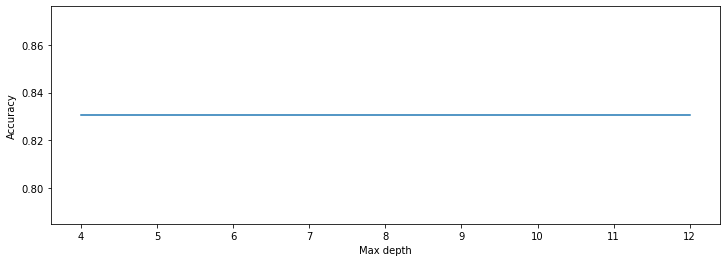

In [66]:
#создадим ряд со значениями точности модели и построим график
plot_score_3 = np.array([results[x] for x in metrics])

plt.figure(figsize=(12,4))
ax = sns.lineplot(x=metrics, y=plot_score_3)
ax.set(ylabel='Accuracy', xlabel='Max depth')
plt.show()

In [67]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with the depth of trees {}'.format(plot_score_3.max(), metrics[plot_score_3.argmax()]))
MAX_DEPTH = metrics[plot_score_3.argmax()]

Max. accuracy 83.06% with the depth of trees 4


In [68]:
#зададим минимальное число объектов, при котором выполняется расщепление в интервале от 2 до 8 с шагом в 1
metrics = [x for x in range(2,9,1)]
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=N_ESTIMATORS, criterion=CRITERION, max_depth=MAX_DEPTH,
                                   min_samples_split=x, min_samples_leaf=MIN_SAMPLES_LEAF).mean()

100%|██████████| 7/7 [01:07<00:00,  9.67s/it]


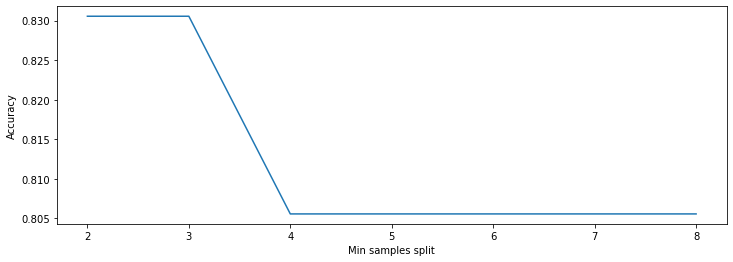

In [69]:
#создадим ряд со значениями точности модели и построим график
plot_score_4 = np.array([results[x] for x in metrics])

plt.figure(figsize=(12,4))
ax = sns.lineplot(x=metrics, y=plot_score_4)
ax.set(ylabel='Accuracy', xlabel='Min samples split')
plt.show()

In [70]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with the min samples split {}'.format(plot_score_4.max(), metrics[plot_score_4.argmax()]))
MIN_SAMPLES_SPLIT=metrics[plot_score_4.argmax()]

Max. accuracy 83.06% with the min samples split 2


In [71]:
#зададим ограничение на число объектов в листьях в интервале от 6 до 14 с шагом в 1
metrics = [x for x in range(6,15,1)]
results = {}
for x in tqdm(metrics):
    results[x] = acc_score(n_estimators=N_ESTIMATORS, criterion=CRITERION, max_depth=MAX_DEPTH,
                                   min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=x).mean()

100%|██████████| 9/9 [01:21<00:00,  9.09s/it]


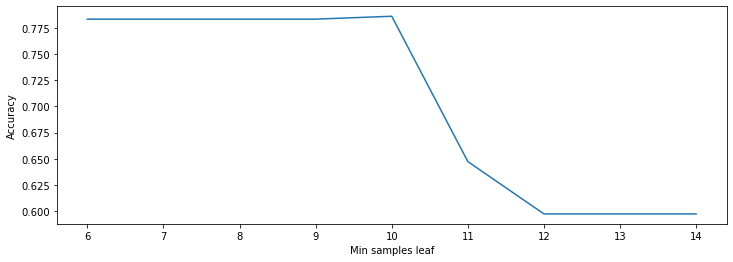

In [72]:
#создадим ряд со значениями точности модели и построим график
plot_score_5 = np.array([results[x] for x in metrics])

plt.figure(figsize=(12,4))
ax = sns.lineplot(x=metrics, y=plot_score_5)
ax.set(ylabel='Accuracy', xlabel='Min samples leaf')
plt.show()

In [73]:
#выведем максимальное значение точности модели и переназначим параметр
print('Max. accuracy {:.2%} with the min samples leaf {}'.format(plot_score_5.max(), metrics[plot_score_5.argmax()]))
MIN_SAMPLES_LEAF=metrics[plot_score_5.argmax()]

Max. accuracy 78.61% with the min samples leaf 10


*Установим все показатели в модель*

In [74]:
model_classifier = RandomForestClassifier(n_estimators=N_ESTIMATORS, criterion=CRITERION, max_depth=MAX_DEPTH,
                                          min_samples_split=MIN_SAMPLES_SPLIT, min_samples_leaf=MIN_SAMPLES_LEAF)
model_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, min_samples_leaf=10, n_estimators=1300)

*Проверим точность модели на валидационных данных*

In [75]:
cross_val_score(model_classifier, X_valid, y_valid, cv = 5)

array([0.55555556, 0.66666667, 0.75      , 0.5       , 0.625     ])

In [76]:
print('Средняя точность модели составляет {:.2%}'.format(model_classifier.score(X_valid, y_valid)))

Средняя точность модели составляет 76.19%


*После второго прохода точность модели снизилась, возможно стоит изменить максимальную глубину и ограничение на число объектов в листьях (min_samples_leaf)*

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

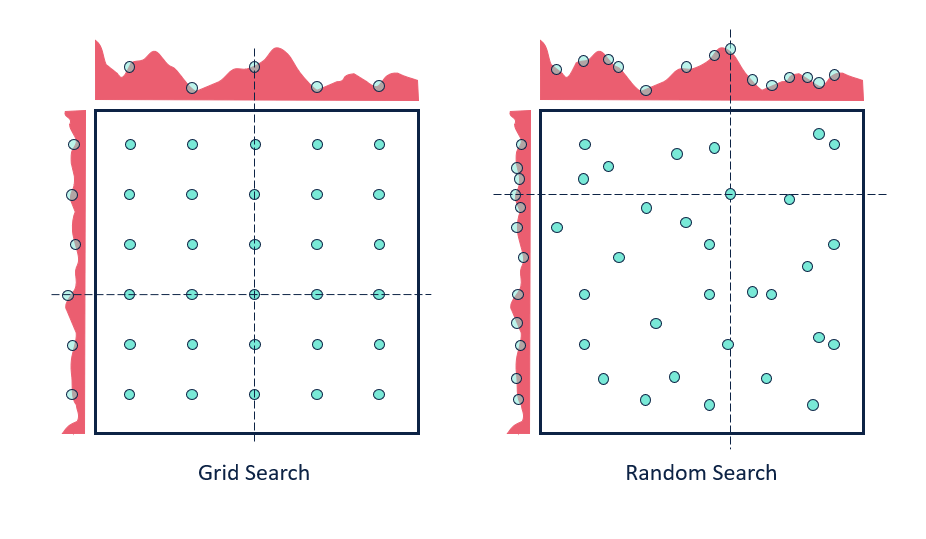

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

In [82]:
parameters = {'n_estimators':[100, 800, 1200],
              'criterion':['gini', 'entropy'],
              'max_depth':[2,4,8],
              'min_samples_split':[2,4,8],
              'min_samples_leaf':[1,2,10]}

In [83]:
c_model = RandomForestClassifier()
clf = GridSearchCV(c_model, parameters, n_jobs=-1)

In [84]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 8], 'min_samples_leaf': [1, 2, 10],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [100, 800, 1200]})

In [85]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

In [86]:
clf.best_score_

0.8383333333333333

*Установим все показатели в модель*

In [94]:
model_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4,
                                          min_samples_split=4, min_samples_leaf=1)
model_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, min_samples_split=4)

*Проверим точность модели на валидационных данных*

In [95]:
cross_val_score(model_classifier, X_valid, y_valid, cv = 5)

array([0.44444444, 0.77777778, 0.375     , 0.75      , 0.75      ])

In [96]:
print('Средняя точность модели составляет {:.2%}'.format(model_classifier.score(X_valid, y_valid)))

Средняя точность модели составляет 83.33%


**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [90]:
ran_clf = RandomizedSearchCV(c_model, parameters, n_jobs=-1)

In [91]:
ran_clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 8],
                                        'min_samples_leaf': [1, 2, 10],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [100, 800, 1200]})

In [92]:
ran_clf.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'max_depth': 2,
 'criterion': 'entropy'}

In [93]:
ran_clf.best_score_

0.8143333333333335

*Установим все показатели в модель*

In [97]:
model_classifier = RandomForestClassifier(n_estimators=800, criterion='entropy', max_depth=2,
                                          min_samples_split=2, min_samples_leaf=10)
model_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=2, min_samples_leaf=10,
                       n_estimators=800)

*Проверим точность модели на валидационных данных*

In [98]:
cross_val_score(model_classifier, X_valid, y_valid, cv = 5)

array([0.44444444, 0.66666667, 0.625     , 0.75      , 0.625     ])

In [99]:
print('Средняя точность модели составляет {:.2%}'.format(model_classifier.score(X_valid, y_valid)))

Средняя точность модели составляет 76.19%


**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

*Ручной метод выбора гиперпараметров удобен в том случае, когда не известен диапазон выбора значений гиперпараметров. Поэтому берутся величины исходя из опыта прошлых применений и на основе их выбирается оптимальный параметр. Данный метод вполне можно заменить случайным поиском значений гиперпараметров (Random Search), т.к. он требует минимум кода и в нём есть встроенные функции кросс-валидации для проверки точности модели. Для более точного подбора гиперпараметров, после выбора через Random Search, можно воспользоваться поиском по сетке (Grid Search), исходя из выбранных значений, которые можно уложить в середину какого-то диапазона и возможно ближайшие значения дадут лучший результат точности модели.*

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible desicion-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [100]:
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression

In [119]:
PATH = "C:/Users/kinkp/Jupyter_note/ml-intro/5_classification_linear_knn/data/"
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [120]:
for d in [data, test_data]:
    d.drop(['Cabin', 'Age'], inplace=True, axis=1) 

In [121]:
y = data['Survived']
data = data.drop('Survived', axis=1)

In [128]:
cat_cols = [cname for cname in data.columns if
                    data[cname].dtype == "object"]
num_cols = [cname for cname in data.columns if 
                data[cname].dtype in ['int64', 'float64']]

In [129]:
data.Embarked.fillna('S', inplace=True)

In [130]:
l_coder = LabelEncoder()

In [134]:
for i in data.columns:
    data[i] = l_coder.fit_transform(data[i])

In [135]:
X_train, X_val, y_train, y_val = train_test_split(data, y, test_size=0.2, random_state=0)

In [136]:
model = DecisionTreeClassifier(criterion='gini', max_depth=3)

In [137]:
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [138]:
model.score(X_val, y_val)

0.8212290502793296

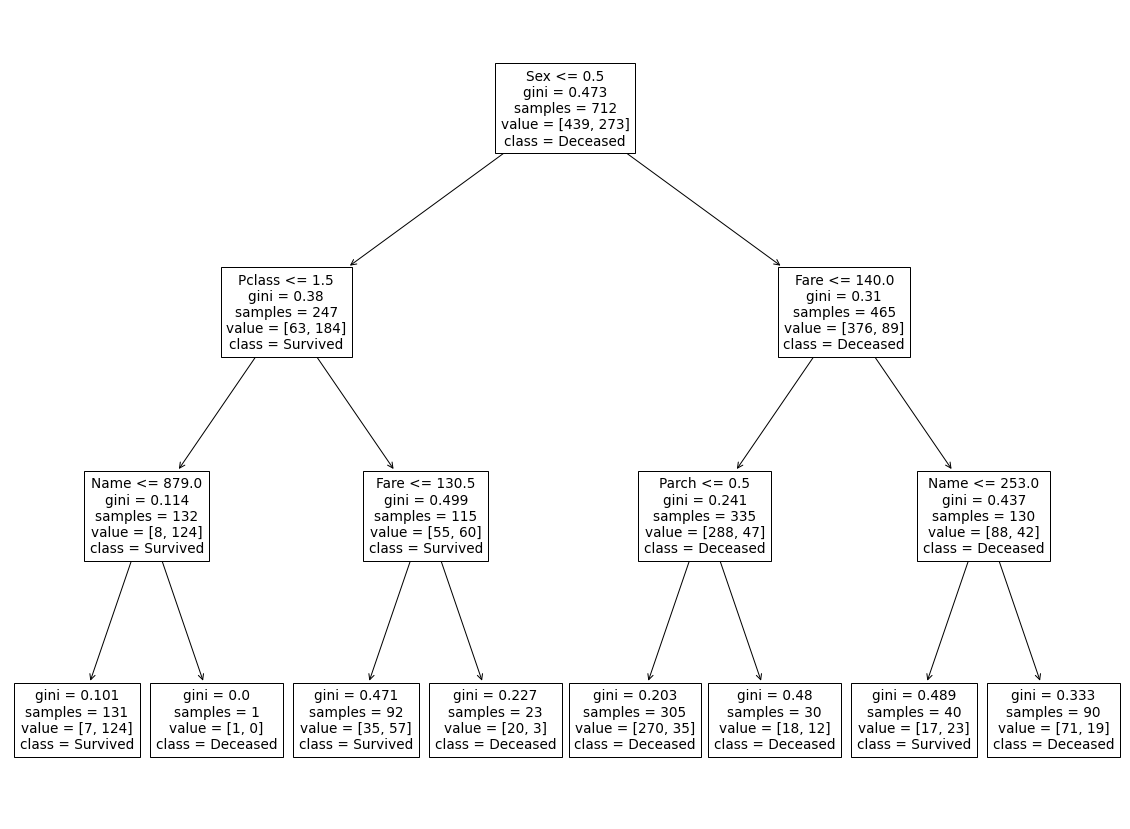

In [139]:
plt.figure(figsize=(20,15))
plot_tree(model, class_names=['Deceased', 'Survived'], feature_names=data.columns)
plt.show()

Is it easy to interpret its results? Are you able to explain to a random person why would he survive / die on the titanic?

*Интерпретировать результаты достаточно легко. Следует указать названия классов и названия признаков, по которым предсказывается целевой класс. В нашем случае это погибший (класс = 0) или выживший (класс = 1). По значениям признаков, можно понять, какие значения повлияли на выживаемость. На графике выше отобразены числовые значения, т.к. был применен LabelEncoder. Но данную кодировку можно вернуть и в текстовое значение, что лучше поможет понять какой из признаков повлиял на выживаемость. Например, по столбцу "Sex", где мужской пол = 1, согласно plot_tree видно что при "Sex <=0.5 модель относит к классу "Deceased".*

# Homework part 2. RandomForestRegressor

**Task 7 (2 points)**. Write your own *DecisionTreeRegressor* class with _MSE_ split criterion and settable parameter *max_depth*. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). <br>

Provide examples for different _max_depth_ parameter.

Of course you may re-use code for *DecisionTreeClassifier*. You need to figure out what needs to be changed in it for Classification -> Regression transformation.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [140]:
import numpy as np

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

In [141]:
# Your code here

**Task 8 (2 points)**. Write your own _RandomForestRegressor_ class with MSE split criterion and settable parameter _max_depth_.  Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).<br>

Provide examples for different max_depth parameter.<br>

**! You are allowed to use only NumPy library** in this assigment.

In [142]:
# Your code here

# Homework part 3 (bonus). Speeding up forest training process

**Task 9 (3 points)** Devise a way to speed up training against the default version of our custom _RandomForestClassifier_ or your own _RandomForestRegressor_. You may want use [`joblib`](https://joblib.readthedocs.io/en/latest/) for parallelizing trees training. Provide graphs of time dependences on the number of trees in your _fast_ version with different number of cores / threads used against default one.

In [ ]:
# Your code here